In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat 
import os
import glob

In [2]:
import pandas as pd
from tqdm.notebook import tqdm
from scipy import interpolate

> The gaze of each subject was tracked monocularly (best or preferred eye) as they viewed an iMac (Apple, Cupertino, CA), mid-2010, 2700
display (60 x 34 cm; 60Hz; 2560 by 1440 pixels; 16:9 aspect ratio) or a Barco F50 projector (Gamle Fredrikstad, Norway) and Stewart Filmscreen (Torrance, CA) Aeroview 70 rear-projection screen to create a 27”display (60 34 cm; 120 Hz; 1920 x 1080 pixels 16:9 aspect ratio) from 1 m away for a 3319
potential viewing area.

In [3]:
path = "../GazeData/NV/"

dirs = os.listdir(path)
subj_names = sorted([f for f in dirs if os.path.isdir(os.path.join(path, f))])

In [4]:
print(subj_names)

['0043er', '0724er', '0811ne', '0972rs', '1613ey', '1744an', '1776yy', '1848ne', '1864nw', '1875td', '1947ne', '2005dh', '2006nh', '2009dl', '2017ae', '2024er', '2025es', '2029ny', '2030nr', '2033kt', '2037sn', '2039nn', '2065ey', '2072ds', '2081lo', '2086ty', '2094ne', '2103en', '2112el', '2130oa', '2133lr', '2139ha', '2141po', '2144dl', '2152so', '2153ng', '2157ss', '2158yn', '2160rz', '2168hd', '2172lt', '2176as', '2180yr', '2221ee', '2237ns', '2270er', '2278te', '2327wn', '2367oo', '2401er', '2464ys', '2700hm', '2702SZ', '2703le', '2719sn', '2720dn', '2753nt', '2764hn', '2775ar', '2781yh', '2789ly', '2792sl', '2802ln']


In [5]:
data_info = pd.read_csv("../30s_segment_description.csv")

In [6]:
data_info

,index,file name,movie name,ch,location in ch (min/frames),length,AR (approx),size,genre (IMDB),genre category,...,human figures (0-5),nature (0-5),man-made objects (0-5),environment,light (0-5),light category,aud. Info,possible question,possible answers,content elements
0,NaN,STEPF_3a,The Stepfather,3,00:33.03/792-01:03.05/1511,30.01s,21x9,853x360,mystery/thriller,a demo (drama/other),...,3,0,2,indoor,2,low,4,NaN,NaN,NaN
1,NaN,APPAL_7a,Appaloosa,7,00:01.70/41-00:31.73/761,30.03s,21x9,853x360,action/crime/drama (Western?),a demo (drama/other),...,4,3,0,outdoor,5,high,3,its hard to tell which characters are speaking...,NaN,NaN
2,NaN,STARD_2b,Stardust,2,04:05.52/5886-04:35.57/6607,30.04s,21x9,853x356,adventure/comedy/family (fantasy?),a demo (drama/other),...,3,3,2,outdoor,1,low,3,describe what the characters are doing,"candlelight picnic, candles on branches, champ...",NaN
3,1.0,Cloud_13a,Cloudy with a Chance of Meatballs,13,00:48.36/1160-01:18.38/1880,30.01s,16x9 (may be 1.77:1 to 1.85:1),853x480,animation/comedy/family,cartoon/animation,...,3,2,1,outdoor,4,high,3,describe the man's expressions and body langua...,NaN,NaN
4,2.0,Cloud_17a,Cloudy with a Chance of Meatballs,17,00:00.00/0-00:30.02/720,30.02s,16x9 (may be 1.77:1 to 1.85:1),853x480,animation/comedy/family,cartoon/animation,...,4,0,4,outdoor,4,high,3,describe the mayor,"extremely obese, white shirt, grey/blue jacket...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,202.0,BLUE_10a_POR,Blue Planet,10,00:00/00-00:30:00/922,30:00s,NaN,480x240,documentary,doc/nature,...,0,5,0,outdoor,4,high,4,NaN,NaN,NaN
205,203.0,NETW_7a_POR,Network,7,00:00/00-00:30:00/922,30:00s,NaN,480x240,drama/history,drama/other,...,5,0,5,indoor,3,medium,3,NaN,NaN,NaN
206,204.0,QUIZ_8a_POR,Quiz Show,8,00:00/00-00:29:00/893,29:00s,NaN,480x256,drama/history,drama/other,...,5,0,5,indoor,3,medium,3,NaN,NaN,NaN
207,205.0,SHAKE_11a_POR,Shakespeare in Love,11,00:00/00-00:30:00/910,30:00s,NaN,480x192,drama/romance,drama/other,...,4,3,1,outdoor,2,low,3,NaN,NaN,NaN


In [7]:
data_dict = {}
for subj in subj_names:
    file_paths = glob.glob(f"{path}{subj}/*.mat")
    video_info =  [int(line.rstrip()) for line in open(f"{path}{subj}/{subj}_videos.txt", 'r', encoding='UTF-8')]
    
    assert len(video_info) == len(file_paths), "num of files are not matched."
    for i in range(len(video_info)):
        v_idx = video_info[i]
        v_name = data_info[data_info["index"] == v_idx]["file name"].item()
        if data_dict.get(v_name) is None:
            data_dict[v_name] = {}
        data_dict[v_name][subj] = file_paths[i]

In [8]:
video_names = sorted(data_dict.keys())

In [9]:
data_exist = np.zeros((len(subj_names), len(video_names)))
for i, v in enumerate(video_names):
    dd = data_dict[v]
    for j, subj in enumerate(subj_names):
        if dd.get(subj):
            data_exist[j, i] = 1
dist_mat = data_exist @ data_exist.T

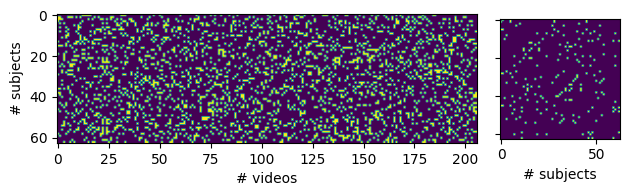

In [10]:
fig, axes = plt.subplots(1,2, width_ratios=[3.5, 1], sharey=True)
axes[0].imshow(data_exist)
axes[0].set_xlabel("# videos")
axes[0].set_ylabel("# subjects")

axes[1].imshow(dist_mat == 0)
axes[1].set_xlabel("# subjects")
#axes[1].set_ylabel("# subjects")
plt.tight_layout()

https://jp.mathworks.com/help/stats/mdscale.html
> mdscale は、D 内の NaN を欠陥値として扱い、それらの要素を無視します。Inf は受け入れられません。

In [11]:
dataset_dir = "../preprocessed_data/clips_png"
movie_info = np.load(f"{dataset_dir}/movie_info.npz", allow_pickle=True)

# display size was checked with check_subj_gaze_pos_hist.ipynb
disp_width = 2560
disp_height = 1440

In [12]:
save_dir = "../preprocessed_data/subj_gaze_pos_upsampled"

In [13]:
#v = video_names[0]
for v in tqdm(video_names):
    print(v)
    gaze_file_path_dict = data_dict[v]
    s_keys = gaze_file_path_dict.keys()

    movie_info_key = None
    for key in movie_info.files:
        if v in key:
            movie_info_key = key
    if movie_info_key:   
        m_info = movie_info[movie_info_key].item()
        fps = m_info["fps"]
        tw = 1e3 / fps
        width, height = m_info["size"]
        duration = m_info["duration"]
        num_frames = m_info["num_frames"]
        
        # upsampling variables
        num_sampling = num_frames * 30
        time_upsample = np.linspace(0, duration*1e3, num_sampling)
        
        # scaling
        ratio_video_gazedata = width / disp_width # display size is 1440 x 2560 or 1080 x 1920 pixels
        y_offset = max((disp_height - height / ratio_video_gazedata) / 2, 0)
        
        gaze_pos_data_dict = {}
        for s_key in s_keys:
            filepath = gaze_file_path_dict[s_key]
            matfile = loadmat(filepath)
            #print(matfile["movieFileName"])
            eyetrackRecord = matfile["eyetrackRecord"]
            t = eyetrackRecord["t"][0, 0][0]
            st = t - t[0]
            #print(st[-1], len(st))
        
            x = eyetrackRecord["x"][0, 0][0]
            y = eyetrackRecord["y"][0, 0][0]
            missing = eyetrackRecord["missing"][0, 0][0]
            missing = missing.astype("bool")
            
            x[missing] = np.nan
            y[missing] = np.nan
            
            xr = x * ratio_video_gazedata
            yr = (y - y_offset) * ratio_video_gazedata
            gp = np.array([xr, yr])
            
            gp_upsampled = []
            for i in range(2):
                f = interpolate.interp1d(st, gp[i], kind="nearest", bounds_error=False, fill_value=np.nan)
                gp_upsampled.append(f(time_upsample))
            gp_upsampled = np.array(gp_upsampled)
            gaze_pos_data_dict[s_key] = gp_upsampled
        np.savez_compressed(f"{save_dir}/{v}.npz", **gaze_pos_data_dict)

  0%|          | 0/206 [00:00<?, ?it/s]

ADVEN_12a
['/Users/woodslab/Desktop/Defocus Video Clips/ADVEN_12a_c 2.mov']
29996 5014
['/Volumes/pelilab/Images & Videos/Videos/TV with LV/Compressed clips/ADVEN_12a_c.mov']
29999 21027
['/Volumes/pelilab/Images & Videos/Videos/TV with LV/Compressed clips/ADVEN_12a_c.mov']
30001 20714
['/Users/woodslab/Desktop/Defocus Video Clips/ADVEN_12a_c 2.mov']
29994 19567
['/Users/woodslab/Desktop/Defocus Video Clips/ADVEN_12a_c 2.mov']
29989 5265
['/Users/woodslab/Desktop/Defocus Video Clips/ADVEN_12a_c 2.mov']
29999 5254
['/Users/woodslab/Desktop/Defocus Video Clips/ADVEN_12a_c 2.mov']
30001 21040
['/Volumes/pelilab/Images & Videos/Videos/TV with LV/Compressed clips/ADVEN_12a_c.mov']
29995 20945
['/Users/woodslab/Desktop/Defocus Video Clips/ADVEN_12a_c 2.mov']
29962 19673
['/Volumes/pelilab/Images & Videos/Videos/TV with LV/Compressed clips/ADVEN_12a_c.mov']
30000 7358
['/Users/woodslab/Desktop/Defocus Video Clips/ADVEN_12a_c 2.mov']
29982 5084
['/Users/woodslab/Desktop/Defocus Video Clips/ADV